In [1]:
last_ckpt = "results_ken/plbart_classifier/checkpoint-172000/trainer_state.json"

In [2]:
import json

In [3]:

state = json.load(open(last_ckpt))

In [4]:
state.keys()

dict_keys(['best_metric', 'best_model_checkpoint', 'epoch', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'max_steps', 'num_train_epochs', 'total_flos', 'trial_name', 'trial_params'])

In [5]:
epochs = [log["epoch"] for log in state["log_history"] if log["epoch"].is_integer()]
losses = [log["loss"] for log in state["log_history"] if log["epoch"].is_integer()]
steps = [log["step"] for log in state["log_history"] if log["epoch"].is_integer()]

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

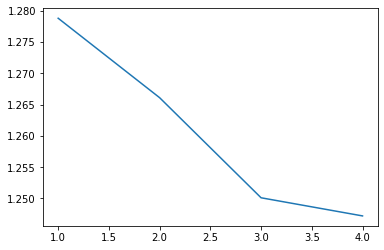

In [7]:
plt.plot(epochs, losses)  # Plot some data on the axes.

In [8]:
steps

[43000, 86000, 129000, 172000]

In [9]:
ckpt_filenames = [f"results_ken/plbart_classifier/checkpoint-{step}" for step in steps]

In [10]:


from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PLBartForSequenceClassification,
)

model = PLBartForSequenceClassification.from_pretrained(
    ckpt_filenames[0], num_labels=27
)

In [11]:
import subprocess
import sys
import os

import torch
import pandas as pd


if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO


def get_free_gpu():
    gpu_stats = subprocess.check_output(
        ["nvidia-smi", "--format=csv", "--query-gpu=memory.used,memory.free"]
    )
    gpu_df = pd.read_csv(
        StringIO(gpu_stats.decode("utf-8")),
        names=["memory.used", "memory.free"],
        skiprows=1,
    )
    print("GPU usage:\n{}".format(gpu_df))
    gpu_df["memory.free"] = gpu_df["memory.free"].map(
        lambda x: int(x.rstrip(" MiB"))
    )
    idx = gpu_df["memory.free"].idxmax()
    print(
        "Returning GPU{} with {} free MiB".format(
            idx, gpu_df.iloc[idx]["memory.free"]
        )
    )
    return idx


free_gpu_id = get_free_gpu()
print(free_gpu_id)

# !pip list
import os

# print (os.environ["CUDA_VISIBLE_DEVICES"])
os.environ["CUDA_VISIBLE_DEVICES"] = str(free_gpu_id)
print(os.environ["CUDA_VISIBLE_DEVICES"])

GPU usage:
  memory.used memory.free
0       2 MiB   24266 MiB
1   23749 MiB     519 MiB
2   23915 MiB     353 MiB
3   20557 MiB    3711 MiB
4   13475 MiB   10793 MiB
5   14264 MiB   10004 MiB
Returning GPU0 with 24266 free MiB
0
0


In [9]:

# import model file
import torch

import numpy as np

# import pandas as pd
from transformers import *
import torch
import torch.nn as nn
import torch.nn.functional as F

# from torch.utils.data import Dataset
from datasets import load_from_disk, load_metric, Dataset

In [10]:

train_plbart_dataset = load_from_disk("datasets/plbart_train.hf")
test_plbart_dataset = load_from_disk("datasets/plbart_test.hf")
# train_plbart_dataset = Dataset.from_dict(train_plbart_dataset[4200:4300])
# test_plbart_dataset = Dataset.from_dict(test_plbart_dataset[4200:4300])
train_plbart_dataset.set_format(
    type="np", columns=["input_ids", "attention_mask", "labels"]
)
test_plbart_dataset.set_format(
    type="np", columns=["input_ids", "attention_mask", "labels"]
)


In [15]:
no_outlier_idx = [idx for idx, _bool in enumerate(train_plbart_dataset["labels"] != -1) if _bool]
train_plbart_dataset.select(no_outlier_idx)

Dataset({
    features: ['line_count', 'comment_count', 'comment_total_len', 'comment_avg_len', 'comment_density', 'id_total', 'lower_case', 'id_total_var', 'lower_case_var', 'snake_case_ratio', 'snake_case_var_ratio', 'snake_case_class_ratio', 'snake_case_method_ratio', 'lower_camel_case_ratio', 'lower_camel_case_var_ratio', 'lower_camel_case_class_ratio', 'lower_camel_case_method_ratio', 'upper_camel_case_ratio', 'upper_camel_case_var_ratio', 'upper_camel_case_class_ratio', 'upper_camel_case_method_ratio', 'lower_case_ratio', 'lower_case_var_ratio', 'lower_case_class_ratio', 'lower_case_method_ratio', 'upper_case_ratio', 'upper_case_var_ratio', 'upper_case_class_ratio', 'upper_case_method_ratio', 'other_case_ratio', 'other_case_var_ratio', 'other_case_class_ratio', 'other_case_method_ratio', 'func_decorators_avg', 'func_async_ratio', 'class_parents_avg', 'class_decorators_avg', 'ds_density', 'ds_char_len_avg', 'ds_word_len_avg', 'comprehensions_avg', 'generators_avg', 'lambda_avg', '

In [13]:

tokenizer = PLBartTokenizer.from_pretrained(
    "uclanlp/plbart-base", src_lang="python", tgt_lang="python"
)
# model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
# train_codet5_dataset = load_from_disk('datasets/codet5_train.hf')
# test_codet5_dataset = load_from_disk('datasets/codet5_test.hf')


unk_id = tokenizer.convert_tokens_to_ids("<unk>")


def replaceNegative(example):
    # print (label['labels'])
    example["labels"] = example["labels"] + 1

    # remove duplicate eos token
    eos_mask = example["input_ids"] == 2
    if len(torch.unique_consecutive(torch.Tensor(eos_mask).sum(1))) > 1:
        invalid_idx = [
            idx for idx, mask in enumerate(eos_mask) if mask.sum() > 1
        ]
        # print(invalid_idx)
        for idx in invalid_idx:
            invalid_token_idx = [
                idx for idx, mask in enumerate(eos_mask[idx]) if mask == 1
            ]
            if len(invalid_token_idx) < 1:
                continue
            for invalid_token_pos in range(len(invalid_token_idx) - 1):
                # print(tokenizer.batch_decode([example["input_ids"][idx]]))
                example["input_ids"][idx][
                    invalid_token_idx[invalid_token_pos]
                ] = unk_id
                # print(tokenizer.batch_decode([example["input_ids"][idx]]))

    return example


train_plbart_dataset = train_plbart_dataset.map(replaceNegative, batched=True)
test_plbart_dataset = test_plbart_dataset.map(replaceNegative, batched=True)
train_plbart_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
test_plbart_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

loading file https://huggingface.co/uclanlp/plbart-base/resolve/main/sentencepiece.bpe.model from cache at /data/users/cting3/.cache/huggingface/transformers/e75bbc4eddf092f59fc4f715f4946a2e8401a821b9c5a4e3f60040dd8c1957ef.c65001d1986897f4ae6d41d2c49f0e1621d3518cab63e0ffa3005e5deb5aae40
loading file https://huggingface.co/uclanlp/plbart-base/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/uclanlp/plbart-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/uclanlp/plbart-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/uclanlp/plbart-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/uclanlp/plbart-base/resolve/main/config.json from cache at /data/users/cting3/.cache/huggingface/transformers/f6e5e7a0536acd8fb984d2eaf2bc23a6c6793d59fe0d72d104e56e1feacb98eb.8929a51af95d04be1b1d966435fd1ad4a48aca2f2953bc4e4a354b1f

In [14]:

train_plbart_dataset = train_plbart_dataset.train_test_split(test_size=0.01)

In [15]:

metric = load_metric("accuracy")


def compute_metrics(
    eval_pred,
):  # this part prob wont work, parameter should be removed from trainer probably
    logits, labels = eval_pred

    predictions = np.argmax(logits[0], axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from torch import nn
from transformers import Trainer



class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(
            weight=torch.tensor([1.0, 2.0, 3.0])
        )  # calculate weights
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels), labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [16]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PLBartForSequenceClassification,
)

training_args = TrainingArguments(
    # change the path cuz I got permission denied...
    output_dir="./results_ken/plbart_classifier_eval_added",
    learning_rate=1e-4,  # 2e-5, #
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    eval_accumulation_steps=100,
)
all_preds = []
for filename in ckpt_filenames:
    model = PLBartForSequenceClassification.from_pretrained(
        filename, num_labels=27
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_plbart_dataset["train"],
        eval_dataset=train_plbart_dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        # data_collator=data_collator,
    )

    preds = trainer.predict(train_plbart_dataset["test"])
    all_preds += [preds]
    break

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file results_ken/plbart_classifier/checkpoint-43000/config.json
Model config PLBartConfig {
  "_name_or_path": "uclanlp/plbart-base",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "PLBartForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
 

In [17]:
[pred.metrics for pred in all_preds]

[{'test_loss': 1.249851942062378,
  'test_accuracy': 0.7594421847762929,
  'test_runtime': 47.8621,
  'test_samples_per_second': 35.957,
  'test_steps_per_second': 2.256}]

In [24]:
all_preds[0].predictions[0].argmax(-1)

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
sum(p.numel() for p in model.parameters())

139832091

In [34]:
pred_labels = all_preds[-1].label_ids

In [35]:
pred_labels_df = pd.DataFrame(pred_labels)

In [36]:
pred_labels_df.to_csv('plbart_preds.csv')

In [1]:
import pandas as pd

In [7]:
pred_df = pd.read_csv("plbart_preds_no_mistake_i_guess.csv")

In [10]:
pred_df = pd.read_csv("plbart_preds_plbart_classifier_no_outliers.csv")

In [2]:
pred_df = pd.read_csv("plbart_preds_plbart_python_classifier_no_outliers.csv")

In [11]:
preds = pred_df.to_numpy()[:, 1]

In [4]:
from datasets import load_from_disk
test_plbart_dataset = load_from_disk("datasets/plbart_test.hf")

In [5]:
golds = [l for l in test_plbart_dataset["labels"] if l != -1]

In [12]:
from sklearn.metrics import classification_report

print(classification_report(golds, preds))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       136
           1       0.51      0.35      0.42       160
           2       0.68      0.75      0.71       103
           3       0.70      0.70      0.70        98
           4       0.69      0.72      0.70       189
           5       0.85      0.82      0.84       233
           6       0.84      0.75      0.79       763
           7       1.00      1.00      1.00      1009
           8       0.96      0.93      0.94       267
           9       0.55      0.67      0.60       206
          10       0.72      0.80      0.75      1113
          11       0.85      0.87      0.86       523
          12       0.87      0.63      0.73       115
          13       0.35      0.37      0.36       168
          14       0.60      0.62      0.61       178
          15       0.52      0.49      0.50       169
          16       0.66      0.66      0.66       538
          17       0.91    

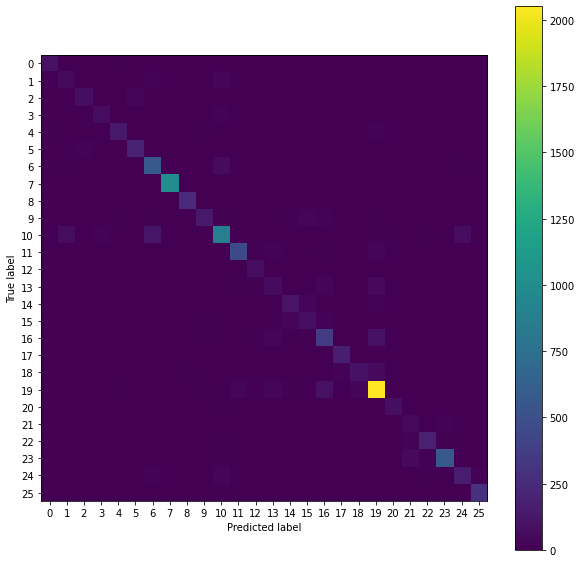

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(preds, golds, include_values=False, ax=ax)
plt.show()